In [167]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [168]:
arith_rgb_to_gray = pd.read_csv("../bench/arith_rgb_to_gray.csv")
linalg_assoc = pd.read_csv("../bench/linalg_assoc.csv")
linalg_3mm = pd.read_csv("../bench/linalg_3mm.csv")
math_inv_sqrt = pd.read_csv("../bench/math_inv_sqrt.csv")
math_horners_method = pd.read_csv("../bench/math_horners_method.csv")

In [169]:
# combine "-O0" col from all dataframes into one dataframe
df = pd.concat([arith_rgb_to_gray, linalg_assoc, linalg_3mm, math_inv_sqrt, math_horners_method], ignore_index=True)
df

,name,opt,-O3
0,arith_rgb_to_gray,canon,24232.5
1,arith_rgb_to_gray,canon+eqsat,20292.5
2,arith_rgb_to_gray,eqsat+canon,20464.0
3,arith_rgb_to_gray,noopt,24358.0
4,arith_rgb_to_gray,eqsat,21414.0
5,linalg_assoc,eqsat,13.0
6,linalg_assoc,noopt,116.5
7,linalg_assoc,canon,114.5
8,linalg_assoc,eqsat+canon,13.0
9,linalg_assoc,cpp,13.0


In [170]:
# Renanem names to nice names
df['name'] = df['name'].replace({
    "arith_rgb_to_gray": "Image Conversion",
    "linalg_assoc": "2MM",
    "linalg_3mm": "3MM",
    "math_inv_sqrt": "Vector Norm",
    "math_horners_method": "Polynomial"
})

df['opt'] = df['opt'].replace({
    "noopt": "No Optimization",
    "canon": "Canonicalization",
    "eqsat": "DragonEgg",
    "eqsat+canon": "DragonEgg + Canonicalization",
    "canon+eqsat": "Canonicalization + DragonEgg",
    "cpp": "MLIR Hand-Writen Pass"
})

In [171]:
df_opt = df[['name', 'opt', "-O3"]]
df_pivot = df_opt.pivot(index='name', columns='opt', values="-O3")
df_pivot

opt,Canonicalization,Canonicalization + DragonEgg,DragonEgg,DragonEgg + Canonicalization,MLIR Hand-Writen Pass,No Optimization
name,,,,,,
2MM,114.5,14.0,13.0,13.0,13.0,116.5
3MM,7776.5,568.0,576.0,563.0,2921.5,7314.0
Image Conversion,24232.5,20292.5,21414.0,20464.0,NaN,24358.0
Polynomial,2109.5,2090.0,1793.0,2090.5,NaN,2002.5
Vector Norm,3262.5,3055.0,3452.0,3395.5,NaN,3108.5


In [172]:
# speedup = baseline / optimized
(1 / df_pivot).mul(df_pivot['No Optimization'], axis=0)

opt,Canonicalization,Canonicalization + DragonEgg,DragonEgg,DragonEgg + Canonicalization,MLIR Hand-Writen Pass,No Optimization
name,,,,,,
2MM,1.017467,8.321429,8.961538,8.961538,8.961538,1.0
3MM,0.940526,12.876761,12.697917,12.991119,2.503508,1.0
Image Conversion,1.005179,1.200345,1.137480,1.190285,NaN,1.0
Polynomial,0.949277,0.958134,1.116843,0.957905,NaN,1.0
Vector Norm,0.952797,1.017512,0.900492,0.915476,NaN,1.0


In [173]:
# create 1 speedup plot for each opt level: [-O0, -O1, -O2, -O3]
# the baseline is opt=noopt
# Filter the dataframe for the current optimization level
df_opt = df[['name', 'opt', "-O3"]]

# Pivot the dataframe to have optimizations as columns
df_pivot = df_opt.pivot(index='name', columns='opt', values="-O3")
df_pivot = df_pivot.drop(columns=['DragonEgg + Canonicalization'], errors='ignore')

# Calculate speedup relative to 'noopt'
df_speedup = (1.0 / df_pivot).mul(df_pivot['No Optimization'], axis=0) 
df_speedup = df_speedup.drop(columns=['No Optimization'], errors='ignore')

# Create the speedup plot
ax = df_speedup.plot(kind='bar', figsize=(10, 6))
plt.grid(True, which='both', axis='y', zorder=0, linestyle=':', linewidth=0.5, alpha=0.7)
plt.rcParams.update({'font.size': 17})

# enable latex
# plt.rc('text', usetex=True)
# plt.rc('font', family='serif')
# plt.rc('text', usetex=True)

# Customize the plot
plt.xlabel('Benchmark', labelpad=10, fontdict={'family': 'Libertine', 'weight': 'bold'})
plt.ylabel(f'Speedup w.r.t. no optimization (log x)', fontdict={'family': 'Libertine', 'weight': 'bold'})
plt.axhline(y=1, color='black', linestyle='-', label='Baseline (No Optimization)')
plt.legend(title='Optimization Passes', loc='upper right', fontsize=17)

# Rotate x-axis labels for better readability
plt.xticks(rotation=0, ha='center')
plt.yscale('log')
plt.ylim(0.5, 30)
plt.yticks([0.5, 1, 5, 10])

# Add speedup numbers on top of each bar
for container in ax.containers:
    # ax.bar_label(container, fmt='%.2f')
    for bar in container:
        bar_height = bar.get_height()
        if not math.isnan(bar_height) and not np.isnan(bar_height) and not math.isinf(bar_height) and not np.isinf(bar_height):
            bar.set_height(bar_height - 1)
            bar.set_y(1)

            # label under the bar if bar_height < 1
            if bar_height < 1:
                ax.text(bar.get_x() + bar.get_width() / 2, bar_height - 0.02, f'{bar_height:.2f}', ha='center', va='top', fontsize=14)
            else:
                ax.text(bar.get_x() + bar.get_width() / 2, bar_height, f'{bar_height:.2f}', ha='center', va='bottom', fontsize=14)

# Adjust layout to prevent cutting off labels
# plt.tight_layout()

# save the plot to a file
plt.savefig("../bench/speedup-O3.pdf")
plt.savefig("/Users/aziz/Documents/2-School/Research Summer 2024/paper/assets/speedup-O3.pdf")

plt.show()

ValueError: Image size of 863x260241 pixels is too large. It must be less than 2^16 in each direction.

<Figure size 1000x600 with 1 Axes>

In [174]:
# create 1 speedup plot for each opt level: [-O0, -O1, -O2, -O3]
# the baseline is opt=noopt
# Filter the dataframe for the current optimization level
df_opt = df[['name', 'opt', "-O3"]]

# Pivot the dataframe to have optimizations as columns
df_pivot = df_opt.pivot(index='name', columns='opt', values="-O3")
df_pivot = df_pivot.drop(columns=['DragonEgg + Canonicalization'], errors='ignore')

# Calculate speedup relative to 'noopt'
df_speedup = (1.0 / df_pivot).mul(df_pivot['No Optimization'], axis=0) 
df_speedup = df_speedup.drop(columns=['No Optimization'], errors='ignore') 

# order is Image Conversion, vector norm, polynomial, 2MM, 3MM
df_speedup = df_speedup.reindex(['Image Conversion', 'Vector Norm', 'Polynomial', '2MM', '3MM'])
df_speedup

opt,Canonicalization,Canonicalization + DragonEgg,DragonEgg,MLIR Hand-Writen Pass
name,,,,
Image Conversion,1.005179,1.200345,1.137480,NaN
Vector Norm,0.952797,1.017512,0.900492,NaN
Polynomial,0.949277,0.958134,1.116843,NaN
2MM,1.017467,8.321429,8.961538,8.961538
3MM,0.940526,12.876761,12.697917,2.503508


In [175]:
df_speedup.index

Index(['Image Conversion', 'Vector Norm', 'Polynomial', '2MM', '3MM'], dtype='object', name='name')

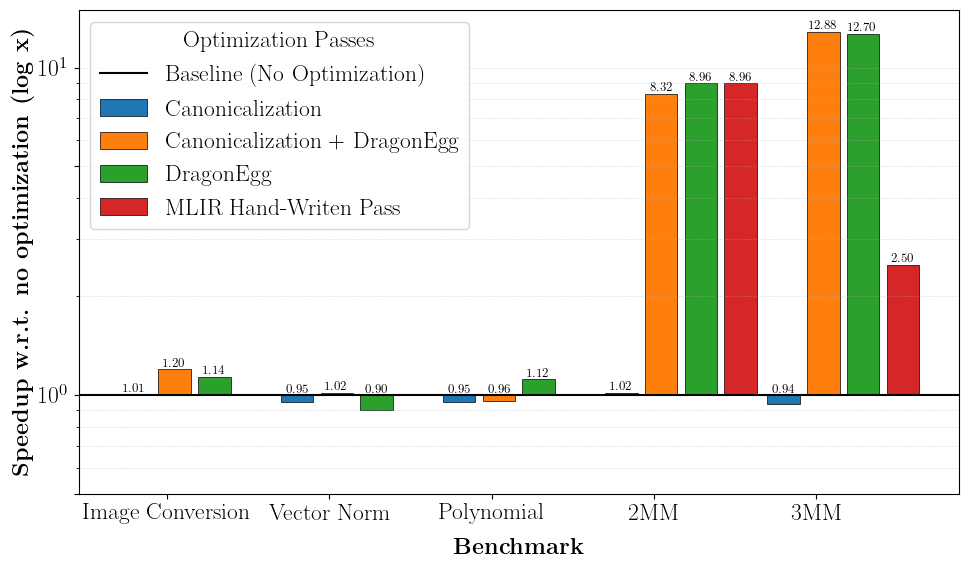

In [176]:
# Create the speedup plot
fig, ax = plt.subplots(figsize=(10, 6))

bar_width = 0.20
space = 0.045
num_bars = len(df_speedup.columns)

index = np.arange(len(df_speedup.index))
group_offset = (num_bars * (bar_width + space)) / 2  # Offset to center bar groups

for i, col in enumerate(df_speedup.columns):
    bars = ax.bar(index + bar_width/2 + i * (bar_width + space), df_speedup[col] - 1, bar_width, 
                  label=col, bottom=1, edgecolor='black', linewidth=0.5)  # Bars start from 1

    # Add text labels on top of each bar
    for bar in bars:
        height = bar.get_height()
        if not np.isnan(height):  # Skip NaN values
            ax.text(bar.get_x() + bar.get_width() / 2, max(0, height) + 1, f'{height + 1:.2f}', ha='center', va='bottom', fontsize=9)

ax.grid(True, which='both', axis='y', zorder=0, linestyle=':', linewidth=0.5, alpha=0.7)
plt.rcParams.update({'font.size': 17})

# Customize the plot
plt.xlabel(r'\textbf{Benchmark}', labelpad=10, fontdict={'family': 'Libertine'})
plt.ylabel(r'\textbf{Speedup w.r.t. no optimization (log x)}', fontdict={'family': 'Libertine', 'weight': 'bold'})
ax.axhline(y=1, color='black', linestyle='-', label='Baseline (No Optimization)')

# Rotate x-axis labels for better readabilit
ax.set_xticks(index + (len(df_speedup.columns) - 1) * bar_width / 2)
ax.set_xticklabels(df_speedup.index, rotation=0, ha='center')

plt.yscale('log')
plt.ylim(0.5, 15)
plt.yticks([0.5, 1, 5, 10])

ax.legend(title='Optimization Passes', loc='upper left', fontsize=17)

# Adjust layout to prevent cutting off labels
plt.tight_layout()

# save the plot to a file
plt.savefig("../bench/speedup-O3.pdf")
plt.savefig("/Users/aziz/Documents/2-School/Research Summer 2024/paper/assets/speedup-O3.pdf")

plt.show()
